<a href="https://colab.research.google.com/github/napaphach/credit-scoring/blob/main/1913906_CreditScoringModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, plot_confusion_matrix, plot_precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, plot_confusion_matrix, plot_precision_recall_curve

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn import model_selection
import lightgbm as lgb
from sklearn import metrics
from scipy.stats import uniform, truncnorm, randint

In [ ]:
Data = pd.read_csv("https://raw.githubusercontent.com/napaphach/credit-scoring/main/credit-scoring.csv")

In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

Here shows that variable MonthlyIncome and Number of Dependents have some missing value

In [ ]:
Data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


**Step 1:Data analysis**


In [ ]:
df = Data.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


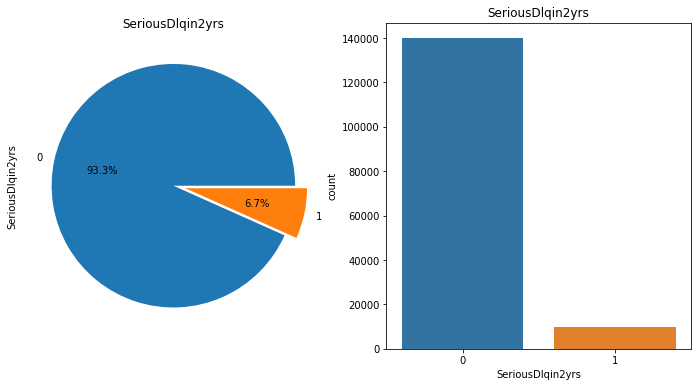

In [ ]:
# Discover imbalance classification
fig, axes = plt.subplots(1,2,figsize=(12,6))
df['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')

sns.countplot('SeriousDlqin2yrs',data=df,ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

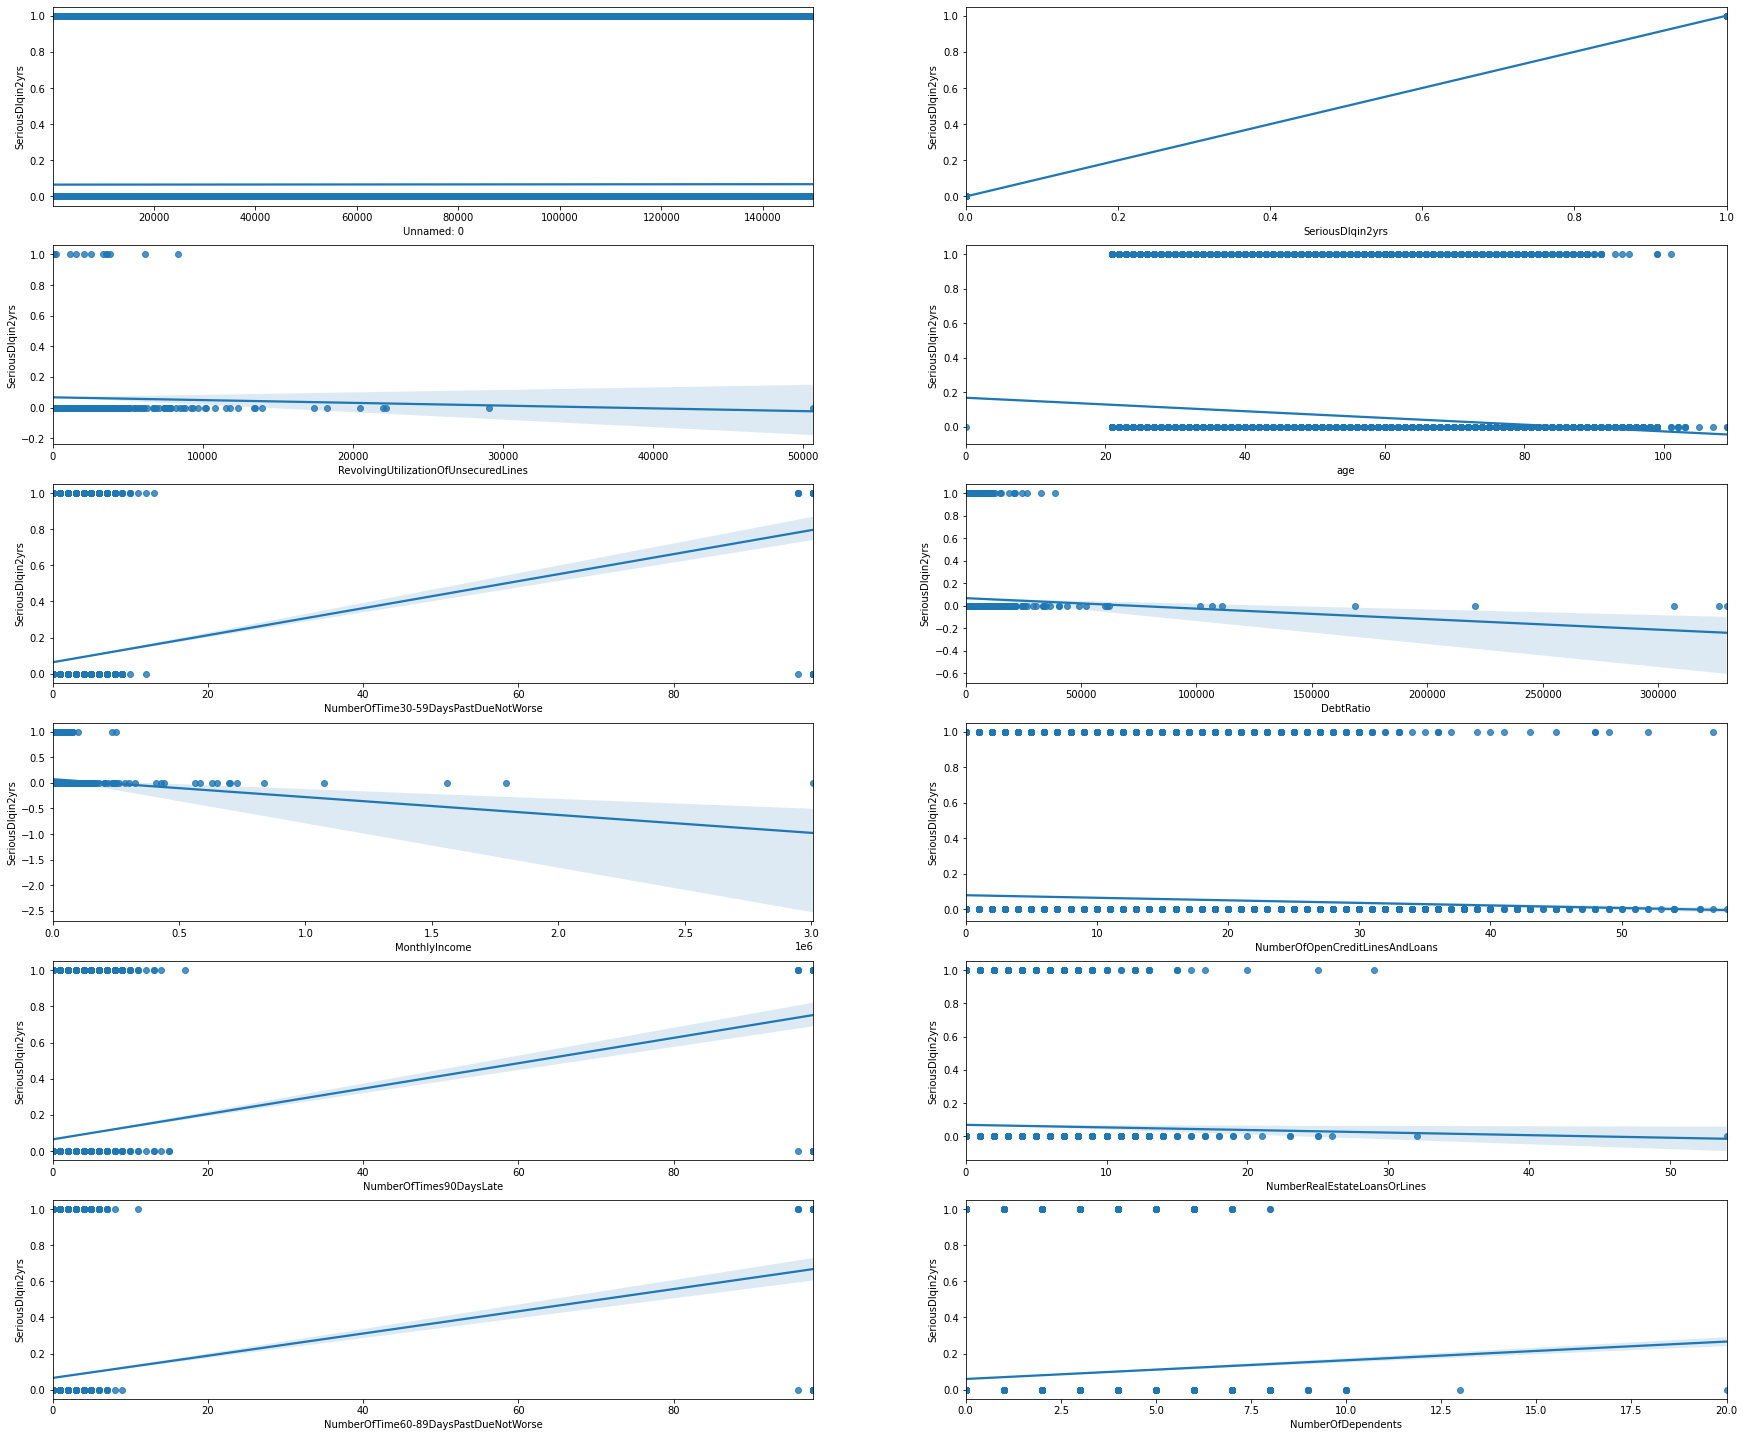

In [ ]:
#Discover outlier
fig = plt.figure(figsize=[30,30])
for col,i in zip(df.columns,range(1,13)):
    axes = fig.add_subplot(7,2,i)
    sns.regplot(df[col],df.SeriousDlqin2yrs,ax=axes)
plt.show()

**Step 2: Data Preprocessing**

**Ourlier Problem solving:**
For **NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate**

In [ ]:
# Checking potential outlier that may caused from value error
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(df[df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))

print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(df[df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))

print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(df[df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))

print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(df[df['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime30-59DaysPastDueNotWorse']))

print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(df[df['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))

print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(df[df['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


In [ ]:
# Replace all potential outlier by a reasonable value from the variables
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
df.loc[df['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

In [ ]:
print("Unique values in 30-59Days", np.unique(df['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(df['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(df['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


**For DebtRatio and RevolvingUtilizationOfUnsecuredLines variables**


In [ ]:
#Check for potential error value
print('Debt Ratio: \n',df['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n',df['RevolvingUtilizationOfUnsecuredLines'].describe())

Debt Ratio: 
 count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines: 
 count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


Data shows a huge differecne between 75th Quantile and the max value of those variables

In [ ]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99,1]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',df.DebtRatio.quantile(i))

75.0 % quantile of debt ratio is:  0.86825377325
80.0 % quantile of debt ratio is:  4.0
81.0 % quantile of debt ratio is:  14.0
85.0 % quantile of debt ratio is:  269.1499999999942
90.0 % quantile of debt ratio is:  1267.0
95.0 % quantile of debt ratio is:  2449.0
97.5 % quantile of debt ratio is:  3489.024999999994
99.0 % quantile of debt ratio is:  4979.040000000037
100 % quantile of debt ratio is:  329664.0


In [ ]:
df[df['DebtRatio'] >= df['DebtRatio'].quantile(0.90)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,15004.000000,850.000000
mean,0.049787,0.195294
std,0.217511,0.396660
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Here we can observe:

Out of 15,004 customers who with debt ratio at greater than 90 quantile, only 850 customers shows monthly income record (the rest is assumed to be those has has missing value of income). Value of monthly income also range from 0 to 1 which assumed to be the reason that make debt ratio extremely high. 

In [ ]:
df = df[-(df["DebtRatio"] >= df["DebtRatio"].quantile(0.90))]
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,149995,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


Hence, those rows that having debt ratio at higher than 90 quantile are eliminated

In [ ]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99,1]

for i in quantiles:
    print(i*100,'% quantile of RevolvingUtilizationOfUnsecuredLines is: ',df.RevolvingUtilizationOfUnsecuredLines.quantile(i))

75.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.571416225
80.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.712657469
81.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.7424545671
85.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.86605134725
90.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.9884857444999999
95.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.9999998999999999
97.5 % quantile of RevolvingUtilizationOfUnsecuredLines is:  0.9999998999999999
99.0 % quantile of RevolvingUtilizationOfUnsecuredLines is:  1.0998020595999995
100 % quantile of RevolvingUtilizationOfUnsecuredLines is:  50708.0


Next, check for variable revolving utilization of unsecured lines, data shows a huge gap between 99 quantile and maximum value

In [ ]:
df[(df["RevolvingUtilizationOfUnsecuredLines"] > df["RevolvingUtilizationOfUnsecuredLines"].quantile(0.99))] [(df['SeriousDlqin2yrs']==0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
293,294,0,2340.000000,45,0,0.339333,8333.0,7,0,2,0,2.0
541,542,0,1.245847,24,1,499.000000,NaN,4,1,0,0,NaN
719,720,0,1.163184,52,0,0.319174,4213.0,7,0,0,0,0.0
900,901,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
1666,1667,0,1.708045,47,0,1.862758,1500.0,6,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149279,149280,0,20514.000000,42,0,0.062102,9902.0,1,1,0,0,2.0
149528,149529,0,1.122041,42,0,0.561305,8000.0,9,0,2,0,2.0
149778,149779,0,1.383886,26,2,0.247826,1839.0,3,1,0,1,0.0
149909,149910,0,1.139721,38,2,0.016734,1732.0,4,0,0,1,3.0


In [ ]:
df[df['RevolvingUtilizationOfUnsecuredLines']>10].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,172.000000,203.000000,203.000000,203.000000,203.000000,195.000000
mean,76448.118227,0.073892,3488.732845,50.359606,0.197044,53.464991,8516.901163,5.807882,0.073892,1.133005,0.093596,0.779487
std,41006.854806,0.262241,5247.417895,14.544699,0.613859,186.984839,6551.123429,3.252956,0.596573,1.120044,0.602066,1.082946
min,294.000000,0.000000,11.385230,24.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,43784.500000,0.000000,860.500000,39.000000,0.000000,0.205505,4552.500000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,75442.000000,0.000000,1917.000000,47.000000,0.000000,0.331641,7000.000000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,108874.500000,0.000000,4074.000000,60.000000,0.000000,0.719163,10120.250000,7.000000,0.000000,2.000000,0.000000,1.000000
max,149280.000000,1.000000,50708.000000,87.000000,3.000000,1195.000000,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


In [ ]:
df[df["RevolvingUtilizationOfUnsecuredLines"]>10] [(df['SeriousDlqin2yrs']==0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
293,294,0,2340.0,45,0,0.339333,8333.0,7,0,2,0,2.0
2331,2332,0,6324.0,59,0,0.136673,11318.0,4,0,1,0,1.0
4278,4279,0,1982.0,33,0,0.144982,8000.0,4,0,0,0,0.0
4793,4794,0,3746.0,52,2,0.481353,2600.0,5,0,1,0,3.0
6760,6761,0,941.0,37,0,0.085183,5000.0,6,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145587,145588,0,7452.0,52,0,0.351365,10000.0,5,0,2,0,3.0
149102,149103,0,6109.0,43,0,0.229902,12500.0,9,0,2,0,0.0
149160,149161,0,22000.0,38,0,1.080020,3973.0,7,0,2,0,3.0
149245,149246,0,771.0,52,0,0.832021,8000.0,13,0,3,0,0.0


This show that 188 customers of 203 customer who has 1000% of credit utilized but never been experined any 90 days past due delinquency or worse. These may bias the estimation, therefore, it will be eliminated. 

In [ ]:
df = df[df['RevolvingUtilizationOfUnsecuredLines']<=10]
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,149995,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


Now obtain training set with 134,793 rows with 12 features

Next, checking for Revolving Utilization of Unsecured Lines. This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [ ]:
df.shape

(134793, 12)

For variable **age, and MonthlyIncome**

In [ ]:
# Another type of error is for example here as a person with age equal to zero
df[df['age']==0].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
mean,65696.0,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,65696.0,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
25%,65696.0,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
50%,65696.0,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
75%,65696.0,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
max,65696.0,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0


In [ ]:
#eliminate this row as it is only one observation
df = df[df['age']>0]
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,149995,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


Now a bit cleaner dataset contains 149430 rows × 11 columns

In [ ]:
df.shape

(134792, 12)

**Dealing with missing value as seen in the begining**

In [ ]:
def MissingHandler(df):
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

MissingHandler(df)

,Percentage Nulls
MonthlyIncome,11.533325
NumberOfDependents,2.028310


There are 11.53% and 2.02% Nulls for MonthlyIncome and NumberOfDependents respectively.

In [ ]:
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
#checking for missing data
MissingHandler(df)

,Percentage Nulls


In [ ]:
print(df.shape)

(134792, 12)


**Step 2: Staistical Describtive**

Text(0.5, 1.0, 'Correlation Matrix (HeatMap)')

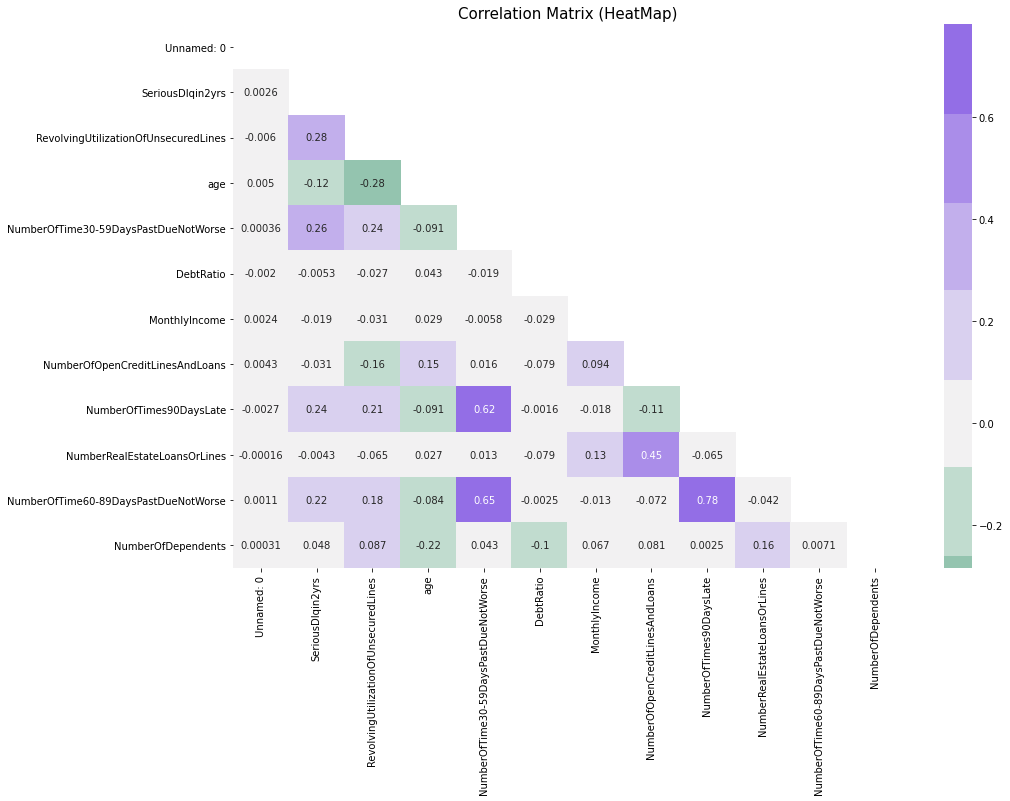

In [ ]:
fig = plt.figure(figsize = [15,10])
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), mask = mask, annot=True, center = 0)
plt.title("Correlation Matrix (HeatMap)", fontsize = 15)

From the correlation heatmap above, we can see the most correlated values to SeriousDlqin2yrs are NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate.

**Step 3: Feature Engineering**

In [ ]:
df.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,134792.000000,134792.000000,134792.000000,134792.000000,134792.000000,134792.000000,1.347920e+05,134792.000000,134792.000000,134792.000000,134792.000000,134792.000000
mean,75009.982180,0.068728,0.326991,52.090428,0.272234,45.868794,6.565278e+03,8.345718,0.127248,0.957579,0.087743,0.769719
std,43300.488053,0.252992,0.368849,15.055594,0.899491,185.410670,1.358144e+04,5.164598,0.900926,1.123874,0.589865,1.118987
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37590.750000,0.000000,0.029856,41.000000,0.000000,0.154934,3.700000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,74972.500000,0.000000,0.156850,51.000000,0.000000,0.324981,5.416000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112523.250000,0.000000,0.568642,63.000000,0.000000,0.587601,7.800000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,8.851852,109.000000,13.000000,1266.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


In [ ]:
SeriousDlqIn2Yrs = df['SeriousDlqin2yrs']
CustomerID = df['Unnamed: 0']
df.drop(['SeriousDlqin2yrs','Unnamed: 0'], axis = 1 , inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134792 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  134792 non-null  float64
 1   age                                   134792 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  134792 non-null  int64  
 3   DebtRatio                             134792 non-null  float64
 4   MonthlyIncome                         134792 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       134792 non-null  int64  
 6   NumberOfTimes90DaysLate               134792 non-null  int64  
 7   NumberRealEstateLoansOrLines          134792 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  134792 non-null  int64  
 9   NumberOfDependents                    134792 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 11.3 MB


Now the dataset contains 134792 entries and without missing value 

**Adding some new features:**
1. MonthlyDebt: Monthly Income multiplied by the Debt Ratio
2. Retired: Person whose monthly income is 0 and age is greater than 65 (Assumed Retirement Age)
3. MultipleRealEstates: If the Number of Real Estates is greater than 2
4. Revolving lines : shows how manythe left over credit lines haven't been used
5. has revolving lines is a dummy variable, 1 if some open credit lines haven't been used and 0 otherwise. 

In [ ]:
df['MonthlyDebt'] = df['MonthlyIncome']*df['DebtRatio']
df['MonthlyDebt'].fillna(df['DebtRatio'],inplace=True)
df['MonthlyDebt'] = np.where(df['MonthlyDebt']==0, df['DebtRatio'],df['MonthlyDebt'])

df['Retired'] = np.where((df['age'] > 65), 1, 0)

df['hasMultipleRealEstates'] = np.where((df['NumberRealEstateLoansOrLines']>=2),1,0)

df['RevolvingLines'] = df['NumberOfOpenCreditLinesAndLoans']-df['NumberRealEstateLoansOrLines']
df['hasRevolvingLines']=np.where((df['RevolvingLines']>0),1,0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134792 entries, 0 to 149999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  134792 non-null  float64
 1   age                                   134792 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  134792 non-null  int64  
 3   DebtRatio                             134792 non-null  float64
 4   MonthlyIncome                         134792 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       134792 non-null  int64  
 6   NumberOfTimes90DaysLate               134792 non-null  int64  
 7   NumberRealEstateLoansOrLines          134792 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  134792 non-null  int64  
 9   NumberOfDependents                    134792 non-null  float64
 10  MonthlyDebt                           134792 non-null  float64
 11  

In [ ]:
df.shape

(134792, 15)

In [ ]:
SeriousDlqIn2Yrs.value_counts()

0    125528
1      9264
Name: SeriousDlqin2yrs, dtype: int64

In [ ]:
MissingHandler(df)

,Percentage Nulls


In [ ]:
X = df
y = SeriousDlqIn2Yrs
X.shape, y.shape

((134792, 15), (134792,))

**Step 4: Model Training**



**4.1 Logistic regression**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=11, stratify=y)
logit = LogisticRegression(random_state=11, solver="saga", penalty="l1", class_weight="balanced", C=1.0, max_iter=500)
scaler = StandardScaler().fit(X_train)



In [ ]:
X_train_scaled = scaler.transform(X_train) #scaling features!
X_test_scaled = scaler.transform(X_test)

In [ ]:
logit.fit(X_train_scaled, y_train)
logit_scores_proba = logit.predict_proba(X_train_scaled)
logit_scores = logit_scores_proba[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
yPredlogit = logit.predict(X_test)

In [ ]:
cv = cross_validate(estimator=logit, X=X_train_scaled, y=y_train, scoring=["f1", "recall", "precision", "accuracy"], cv=10, n_jobs=-1, return_train_score=True, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


In [ ]:
cv

{'fit_time': array([30.13099742, 30.19736862, 30.22932625, 30.52537394, 28.14227676,
        30.41282034, 30.52726245, 25.24095345, 30.07955217, 29.25396681]),
 'score_time': array([0.02550912, 0.02721691, 0.02380395, 0.02319479, 0.02390122,
        0.0243845 , 0.02361465, 0.0236876 , 0.02371287, 0.01437187]),
 'test_accuracy': array([0.80097505, 0.79655832, 0.79674952, 0.79282983, 0.79359465,
        0.7998088 , 0.80516252, 0.80248566, 0.79913958, 0.79646272]),
 'test_f1': array([0.33397313, 0.32229299, 0.33312422, 0.3200502 , 0.32720474,
        0.33734177, 0.34553629, 0.3403576 , 0.31719207, 0.32605255]),
 'test_precision': array([0.21525773, 0.20746207, 0.21351025, 0.20514883, 0.20933014,
        0.21675478, 0.22286661, 0.21916118, 0.2053008 , 0.20943473]),
 'test_recall': array([0.7446505 , 0.72182596, 0.7574893 , 0.7275321 , 0.7489301 ,
        0.76034237, 0.76857143, 0.76142857, 0.69714286, 0.73571429]),
 'train_accuracy': array([0.79890588, 0.79984279, 0.79717658, 0.79852562, 0

In [ ]:
print(f"Accuracy (Tr/Te): {np.mean(cv['train_accuracy']) * 100:.2f}%/{np.mean(cv['test_accuracy']) * 100:.2f}%")
print(f"Recall (Tr/Te): {np.mean(cv['train_recall']) * 100:.2f}%/{np.mean(cv['test_recall']) * 100:.2f}%")
print(f"Precision (Tr/Te): {np.mean(cv['train_precision']) * 100:.2f}%/{np.mean(cv['test_precision']) * 100:.2f}%")
print(f"F1 (Tr/Te): {np.mean(cv['train_f1']) * 100:.2f}%/{np.mean(cv['test_f1']) * 100:.2f}%")

Accuracy (Tr/Te): 79.82%/79.84%
Recall (Tr/Te): 74.27%/74.24%
Precision (Tr/Te): 21.23%/21.24%
F1 (Tr/Te): 33.03%/33.03%


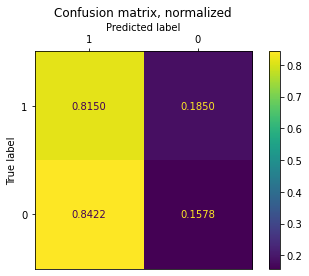

In [ ]:
fig, ax = plt.subplots(1, 1)
disp = plot_confusion_matrix(
    logit, X_test, y_test,
    normalize='true', 
    display_labels=['1', '0'], 
    values_format='.4f', 
    ax=ax)
ax.set_title('Confusion matrix, normalized')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

**4.2 Random Forest**

In [ ]:
X_trainFR, X_testFR, y_trainFR, y_testFR = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=11, stratify=y)

In [ ]:
X_trainFR.shape, y_trainFR.shape

((104601, 15), (104601,))

In [ ]:
X_testFR.shape, y_testFR.shape

((44829, 15), (44829,))

In [ ]:
pipeline = make_pipeline(
    make_column_transformer(
        (make_pipeline(
            MinMaxScaler(),
        ), ["RevolvingUtilizationOfUnsecuredLines", "age",	"NumberOfTime30-59DaysPastDueNotWorse",	"DebtRatio",
            "MonthlyIncome",	"NumberOfOpenCreditLinesAndLoans",	"NumberOfTimes90DaysLate",	"NumberRealEstateLoansOrLines",	
            "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfDependents", "MonthlyDebt","RevolvingLines"]),
    remainder="passthrough"),
    #SMOTE(),
    RandomUnderSampler(),
    RandomForestClassifier(random_state=11, n_jobs=-1)
)
pipeline = pipeline.fit(X_trainFR, y_trainFR)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
cv = cross_validate(pipeline, X_trainFR, y_trainFR, cv=10, scoring=["f1"], n_jobs=-1, return_train_score=True)

In [ ]:
cv

In [ ]:
#UnderSampler
print(f"F1 score on the training set: {cv['train_f1'].mean() * 100:.2f}%")
print(f"F1 score on the test set: {cv['test_f1'].mean() * 100:.2f}%")

F1 score on the training set: 41.85%
F1 score on the test set: 32.36%


In [ ]:
#With over sampler (SMOTE) 
print(f"F1 score on the training set: {cv['train_f1'].mean() * 100:.2f}%")
print(f"F1 score on the test set: {cv['test_f1'].mean() * 100:.2f}%")

F1 score on the training set: 98.31%
F1 score on the test set: 37.00%


It is clear that that over sampler method induce overfitting of the model, therfore, parameter tuning will be based on model with undersampling

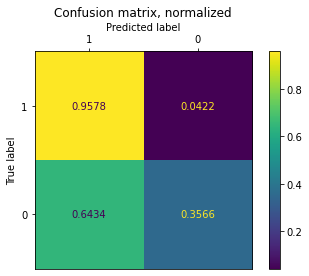

In [ ]:
fig, ax = plt.subplots(1, 1)
disp = plot_confusion_matrix(pipeline
    , X_testFR, y_testFR,
    normalize='true', 
    display_labels=['1', '0'], 
    values_format='.4f',
    ax=ax)
ax.set_title('Confusion matrix, normalized')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

**Random forest Hyperparameter tuning**

In [ ]:
from scipy.stats import uniform, truncnorm, randint
distributions = {
    "randomforestclassifier__n_estimators": randint(low=100, high=500),
    "randomforestclassifier__max_depth": randint(low=50, high=200),
    "randomforestclassifier__max_features": truncnorm(a=0, b=1, loc=0.25, scale=0.1), 
    "randomforestclassifier__min_samples_split": uniform(0.01, 0.199),
    "randomforestclassifier__min_samples_leaf" : randint(low=1, high=4)
}

In [ ]:
model = RandomizedSearchCV(pipeline, distributions, n_iter=3, 
                           scoring=None, n_jobs=-1, random_state=11, cv=5, verbose=1,
                           return_train_score=True, refit=True)
model = model.fit(X_trainFR, y_trainFR)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(f"F1 score on the training set: {model.cv_results_['mean_train_score'][model.best_index_] * 100:.2f}%")
print(f"F1 score on the test set: {model.cv_results_['mean_test_score'][model.best_index_] * 100:.2f}%")

F1 score on the training set: 80.40%
F1 score on the test set: 80.33%


In [ ]:
model.best_params_

{'randomforestclassifier__max_depth': 132,
 'randomforestclassifier__max_features': 0.2694341746045786,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 0.10698694985665445,
 'randomforestclassifier__n_estimators': 401}

In [ ]:
model.cv_results_

In [ ]:
y_predFR =model.predict(X_testFR)

In [ ]:
y_predFR

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [ ]:
f"F1 score on final test set: {f1_score(y_testFR, y_predFR) *100:.2f}%"

'F1 score on final test set: 33.39%'

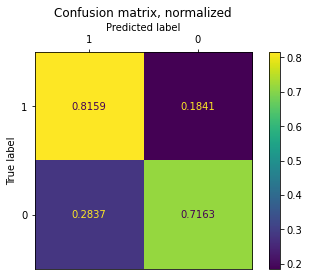

In [ ]:
fig, ax = plt.subplots(1, 1)
disp = plot_confusion_matrix(
    model, X_testFR, y_testFR,
    normalize='true', 
    display_labels=['1', '0'], 
    values_format='.4f',
    ax=ax)
ax.set_title('Confusion matrix, normalized')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [ ]:
model_probs = model.predict_proba(df)
modelDF = pd.DataFrame({'ID': CustomerID, 'Probability': model_probs[:,1]})
modelDF.to_csv('Predicted.csv', index=False)

In [ ]:
modelDF

,ID,Probability
0,1,0.667688
1,2,0.563193
2,3,0.820011
3,4,0.310380
4,5,0.637241
...,...,...
149995,149996,0.180733
149996,149997,0.261216
149997,149998,0.250957
149998,149999,0.230995


**4.3 LightGBM**

In [ ]:
X_trainLG, X_testLG, y_trainLG, y_testLG = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=11, stratify=y)
logit = LogisticRegression(random_state=11, solver="saga", penalty="l1", class_weight="balanced", C=1.0, max_iter=500)
scaler = StandardScaler().fit(X_trainLG)

In [ ]:
X_trainLG.shape, y_trainLG.shape

((94354, 15), (94354,))

In [ ]:
X_testLG.shape, y_testLG.shape

((40438, 15), (40438,))

In [ ]:
from scipy.stats import uniform, truncnorm, randint
lgbAttributes = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=11, importance_type='gain')
lgbParameters = {
    'n_estimators' :randint(low=100, high=900),
    'max_depth' : randint(low=2, high=10),
    'learning_rate': uniform(0.01, 0.15),
    'colsample_bytree' : uniform(0.2, 1),  
    'min_split_gain' : uniform(0.15, 0.35),
    'subsample': uniform(0.5, 1),
    'min_child_weight':  randint(low=6, high=10),
    'scale_pos_weight': randint(low=10, high=20),
    'min_data_in_leaf' : randint(low=100, high=900),
    'num_leaves' : randint(low=20, high=80),
}

lgbModel = model_selection.RandomizedSearchCV(lgbAttributes, param_distributions = lgbParameters, cv = 5, random_state=11)

lgbModel.fit(X_trainLG, y_trainLG,feature_name=df.columns.to_list())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: bagging_fraction <=1.0 at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 295 .


  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: feature_fraction <=1.0 at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 303 .


  FitFailedWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=11, reg_alpha=0.0,
                                            reg_lambda=0.0, sil...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6db7b88c10

In [ ]:
bestEstimatorLGB = lgbModel.best_estimator_
bestEstimatorLGB

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.3897027069240719, importance_type='gain',
               learning_rate=0.040601406594732284, max_depth=3,
               min_child_samples=20, min_child_weight=9, min_data_in_leaf=345,
               min_split_gain=0.4211907149094357, n_estimators=539, n_jobs=-1,
               num_leaves=35, objective='binary', random_state=11,
               reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=10, silent=True,
               subsample=0.9797972816594304, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
bestEstimatorLGB = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.3897027069240719, importance_type='gain',
               learning_rate=0.040601406594732284, max_depth=3,
               min_child_samples=20, min_child_weight=9, min_data_in_leaf=345,
               min_split_gain=0.4211907149094357, n_estimators=539, n_jobs=-1,
               num_leaves=35, objective='binary', random_state=11,
               reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=10, silent=True,
               subsample=0.9797972816594304, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
bestEstimatorLGB.fit(X_trainLG, y_trainLG,feature_name=df.columns.to_list())
y_PredLGB = bestEstimatorLGB.predict(X_testLG)

In [ ]:
y_PredLGB

array([1, 0, 0, ..., 0, 0, 0])

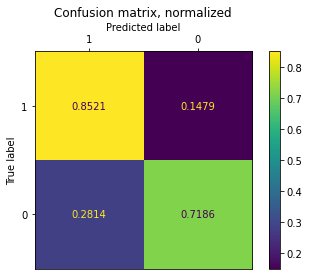

In [ ]:
fig, ax = plt.subplots(1, 1)
disp = plot_confusion_matrix(
    bestEstimatorLGB, X_testLG, y_testLG,
    normalize='true', 
    display_labels=['1', '0'], 
    values_format='.4f', 
    ax=ax)
ax.set_title('Confusion matrix, normalized')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

**5. Evaluation Metrics**

In [ ]:
#test
LGBMMetrics = pd.DataFrame({'Model': 'LightGBM',
                            'MSE': round(metrics.mean_squared_error(y_testLG, y_PredLGB)*100,2), 
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_testLG, y_PredLGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_testLG, y_PredLGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_testLG, y_PredLGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_testLG, y_PredLGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(X_trainLG, y_trainLG) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(X_testLG, y_testLG) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_testLG, y_PredLGB, beta=2)*100,2)},index=[1])

LGBMMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LightGBM,15.7,3.96,15.7,7.54,2.75,84.41,84.3,53.45


In [ ]:
RFMetrics = pd.DataFrame({'Model': 'RandomForest', 
                             'MSE': round(metrics.mean_squared_error(y_testFR, y_predFR)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_testFR, y_predFR)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_testFR, y_predFR)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_testFR, y_predFR)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_testFR, y_predFR)*100),2),
                            'Accuracy Train' : round(model.score(X_trainFR, y_trainFR) * 100,2),
                            'Accuracy Test' : round(model.score(X_testFR, y_testFR) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_testFR, y_predFR, beta=2)*100,2)},index=[1])

RFMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,RandomForest,19.46,4.41,19.46,9.35,3.06,80.08,80.54,49.45


In [ ]:
LogitMetrics = pd.DataFrame({'Model': 'LogisticRegression', 
                            'MSE': round(metrics.mean_squared_error(y_test, yPredlogit)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yPredlogit)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yPredlogit)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yPredlogit)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yPredlogit)*100),2),
                            'Accuracy Train' : round(logit.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(logit.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yPredlogit, beta=2)*100,2)},index=[1])

LogitMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LogisticRegression,22.9,4.79,22.9,11.0,3.32,76.95,77.1,11.72


In [ ]:
frames = [LGBMMetrics, RFMetrics, LogitMetrics]
TrainingResult = pd.concat(frames)
TrainingResult.T

,1,1,1
Model,LightGBM,RandomForest,LogisticRegression
MSE,16.66,19.46,22.9
RMSE,4.08,4.41,4.79
MAE,16.66,19.46,22.9
MSLE,8.01,9.35,11
RMSLE,2.83,3.06,3.32
Accuracy Train,85.34,80.08,76.95
Accuracy Test,85.36,80.54,77.1
F-Beta Score (β=2),52.02,49.45,11.72


**6. Final prediction using LightGBM**

In [ ]:
lgb_probs = bestEstimatorLGB.predict_proba(df)
model_lgbm = pd.DataFrame({'ID': CustomerID, 'Probability': lgb_probs[:,1]})
model_lgbm.to_csv('LGBMPredicted.csv', index=False)
model_lgbm


,ID,Probability
0,1,0.865253
1,2,0.487650
2,3,0.799620
3,4,0.226369
4,5,0.592977
...,...,...
149995,149996,0.044900
149996,149997,0.199991
149997,149998,0.160817
149998,149999,0.080863
